## Creating an AI to play CartPole using the REINFORCE algorithm with PyTorch

In [1]:
# Import stuff
import sys, time
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# Define the shape of the policy network. Here, we will use a simple feedforward
# neural network with one hidden layer.
class PolicyNetwork(nn.Module):
    def __init__(self, n_inputs, n_actions, hidden_size, learning_rate=1e-3):
        super().__init__()
        self.n_actions = n_actions
        self.fc1 = nn.Linear(n_inputs, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)  # convert to probabilities
        return x
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        state = state.to(device)
        probs = self.forward(state)
        action = np.random.choice(self.n_actions, p=probs.to("cpu").detach().squeeze(0).numpy())
        log_prob = torch.log(probs.squeeze(0)[action])
        return action, log_prob
    
    def update(self, all_rewards, all_log_probs, discount_rate=0.9):
        # Compute discounted rewards
        all_discounted_rewards = []
        for rewards in all_rewards:    
            total_reward = 0
            discounted_rewards = [0] * len(rewards)
            for i in reversed(range(len(rewards))):
                discounted_rewards[i] = rewards[i] + discount_rate * total_reward
                total_reward = discounted_rewards[i]
            all_discounted_rewards.append(discounted_rewards)

        # Stack all rewards and log-probs
        flat_discounted_rewards = [r for rewards in all_discounted_rewards for r in rewards]
        flat_log_probs = [lp for log_probs in all_log_probs for lp in log_probs]
        
        # Convert to tensors
        discounted_rewards = torch.tensor(flat_discounted_rewards).to(device)
        log_probs = torch.stack(flat_log_probs).to(device)
        
        # Normalize rewards. This speeds up training by reducing variance.
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        
        # Reset parameter gradients
        self.optimizer.zero_grad()
        
        # Get "loss". This isn't the actual loss function, but its gradient matches the
        # gradient of the actual loss function.
        loss = torch.mul(discounted_rewards, -log_probs).sum()
        
        # Perform back-propagation
        loss.backward()
        
        # Optimize
        self.optimizer.step()

In [3]:
# Create the environment
env = gym.make('CartPole-v0')
env.seed(42)

# Create the policy network
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128).to(device)

In [4]:
# A function to simulate an episode
def simulate(env, policy_net, max_steps=10000, frame_per_second=30):
    second_per_frame = 1 / frame_per_second
    total_reward = 0
    state = env.reset()
    
    for i in range(max_steps):
        env.render()
        
        action, log_prob = policy_net.get_action(state)
        new_state, reward, done, _ = env.step(action)
        total_reward += reward
        
        if done:
            print("Total reward:", total_reward)
            break
        
        state = new_state
        time.sleep(second_per_frame)
        
    env.close()

In [5]:
# Training parameters
n_epochs = 200
episodes_per_epoch = 10
max_steps = 10000

# Track average steps per epoch
avg_steps = []

# Optional simulation parameters to show progress
show_simulation = True
epoch_per_simulation = 25

# Training loop
for epoch in range(n_epochs):
    all_rewards = []
    all_log_probs = []
    total_steps = 0
    
    for episode in range(episodes_per_epoch):
        rewards = []
        log_probs = []
        
        # Collect a trajectory
        state = env.reset()
        for steps in range(max_steps):
            action, log_prob = policy_net.get_action(state)
            new_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            
            if done:
                total_steps += steps
                break
            else:
                state = new_state
                
        all_rewards.append(rewards)
        all_log_probs.append(log_probs)
        
    # Update the policy
    policy_net.update(all_rewards, all_log_probs)
    
    # Track average steps
    avg_step = total_steps / episodes_per_epoch
    avg_steps.append(avg_step)
    
    print("Epoch {}: {}".format(epoch, avg_step))
    
    # Simulate agent (optional)
    if show_simulation and epoch % epoch_per_simulation == 0:
        simulate(env, policy_net)

Epoch 0: 21.9
Total reward: 9.0
Epoch 1: 14.7
Epoch 2: 19.0
Epoch 3: 15.5
Epoch 4: 20.1
Epoch 5: 18.0
Epoch 6: 17.8
Epoch 7: 18.3
Epoch 8: 22.5
Epoch 9: 24.2
Epoch 10: 21.8
Epoch 11: 14.8
Epoch 12: 24.1
Epoch 13: 18.0
Epoch 14: 17.8
Epoch 15: 20.1
Epoch 16: 18.8
Epoch 17: 15.6
Epoch 18: 13.7
Epoch 19: 22.6
Epoch 20: 25.1
Epoch 21: 32.9
Epoch 22: 24.2
Epoch 23: 32.0
Epoch 24: 22.6
Epoch 25: 23.2
Total reward: 11.0
Epoch 26: 33.1
Epoch 27: 24.2
Epoch 28: 31.9
Epoch 29: 28.5
Epoch 30: 30.1
Epoch 31: 23.0
Epoch 32: 34.5
Epoch 33: 23.4
Epoch 34: 35.3
Epoch 35: 31.1
Epoch 36: 28.5
Epoch 37: 32.8
Epoch 38: 25.3
Epoch 39: 41.5
Epoch 40: 41.8
Epoch 41: 37.2
Epoch 42: 42.8
Epoch 43: 45.0
Epoch 44: 23.7
Epoch 45: 46.2
Epoch 46: 21.3
Epoch 47: 40.6
Epoch 48: 48.7
Epoch 49: 24.0
Epoch 50: 48.5
Total reward: 22.0
Epoch 51: 45.8
Epoch 52: 54.0
Epoch 53: 51.2
Epoch 54: 44.2
Epoch 55: 58.9
Epoch 56: 48.6
Epoch 57: 34.1
Epoch 58: 43.3
Epoch 59: 40.6
Epoch 60: 61.0
Epoch 61: 58.3
Epoch 62: 66.0
Epoch 63:

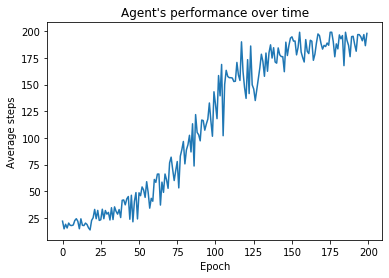

In [6]:
# Plot the agent's performance over time
plt.plot(avg_steps)
plt.title("Agent's performance over time")
plt.xlabel("Epoch")
plt.ylabel("Average steps")
plt.show()

In [7]:
# Simulate the final model
simulate(env, policy_net)

Total reward: 129.0
